In [2]:
"""
This project aims to replicate pandas.ai using Langgraph.

"""
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import pandas as pd
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import HumanMessage
from typing import Optional,Type,Literal,TypedDict
from pydantic import BaseModel
from typing import List
from IPython.display import display,Image

load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")


In [22]:
movie_data_set = pd.read_csv('./sample_100mb.csv')
movie_data_set.drop(columns=['Unnamed: 0'],inplace=True)

In [23]:
movie_data_set[2:3].to_dict(orient='records')

[{'CustId': 2317620,
  'Rating': 3,
  'Date': '2003-12-31',
  'MovieId': 7509,
  'ReleaseYear': 2002,
  'MovieTitle': 'Die Another Day'}]

In [24]:
movie_data_set[:1]

,CustId,Rating,Date,MovieId,ReleaseYear,MovieTitle
0,2004524,1,2004-03-20,5113,1985,Subway


In [ ]:
#state
class DataState(TypedDict):
    user_query : str # at invoke
    columns :List[str] # at invoke
    dataset_name : str # at invoke
    llm_response : str
    user_to_response: List[dict]
    error_message : str | None = None
    retry_on_error : int = 2


# df.head().to_string(index=False)

In [82]:
# Prompts
def process_user_query(state:DataState):
    return f"""
        You are an AI assistant for data analysis. Your task is to generate Python code directly without any additional text, formatting, or prefixes like "python" or "```". 

        Do not include imports, comments, or any other text. Assume the following:
        1. Pandas and NumPy are already installed and imported.
        2. The dataset is loaded into a DataFrame with the name: {state['dataset_name']}.
        3. The dataset has the following columns: {state['columns']}.

        Based on the user query: "{state['user_query']}", generate the exact Python code to execute the query on the dataset.
    """
def generate_error_prompt(state:DataState):
    return f"""
    The generated code caused the following error: {state['error_message']}.
    Please rectify the error and regenerate the correct Python code for the query: "{state['user_query']}".
    """
def summarize_prompt(state:DataState):
    return f"""
        You are an AI assistant. The user asked the following query: "{state['user_query']}".

        The response retrieved from the dataset is as follows:
        {state['user_to_response']}

        Please summarize this response in a concise and clear manner relevant to the user query.
    """ 
    

In [83]:
# Nodes
def generate_llm_response(state : DataState):
    print("generate_llm_response called")
    response = llm.invoke([HumanMessage(content=process_user_query(state=state))])
    # print("response : ",response)
    # response = "movie_data_set.hea()" # wrong query
    state['llm_response'] = response.content
    return state

def call_llm_again(state: DataState):
    print("call_llm_again called ")
    response = llm.invoke([HumanMessage(content=generate_error_prompt(state=state))])
    print("response again : ",response)
    # response = "movie_data_set.head()" # correct query
    state['llm_response'] = response.content
    return state


def summarize_response(state:DataState):
    print("summarize_response called ")
    if state['retry_on_error'] > 0:
        response  = llm.invoke([HumanMessage(content=summarize_prompt(state=state))])
        state['user_to_response'] = response.content
    else:
        state['user_to_response'] = f"Exhausted the limit of retry. Please write the code manually. The recent error is {state['error_message']}"
    return state


def fail_condition(state:DataState):
        
    if state['error_message']:
        if state['retry_on_error'] > 0:
            return 'call_llm_again'
        return 'summarize_response'
    return 'summarize_response'


        
def execute_query(state:DataState):
    try: 
        local_vars = {"movie_data_set": movie_data_set}
        exec(f"result = {state['llm_response']}", {}, local_vars)
        state['user_to_response']  = local_vars['result'].to_dict(orient='records')
        state['error_message'] =  None
        return state
        
    except Exception as e:
        print("LLm Response :",state['llm_response'] ,"\n\n")
        print("Error : ", e)
        state['error_message'] = e
        return state

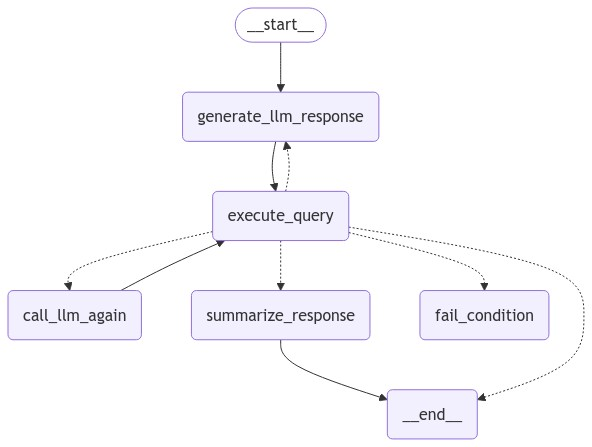

In [84]:
builder = StateGraph(DataState)
builder.add_node('generate_llm_response',generate_llm_response)
builder.add_node('execute_query',execute_query)
builder.add_node('call_llm_again',call_llm_again)
builder.add_node('summarize_response',summarize_response)
builder.add_node('fail_condition',fail_condition)


builder.add_edge(START,'generate_llm_response')
builder.add_edge('generate_llm_response','execute_query')
builder.add_conditional_edges('execute_query',fail_condition)
builder.add_edge('call_llm_again','execute_query')
builder.add_edge('summarize_response',END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
init_state = {
    'user_query': 'Give last row of the given dataset.',
    'columns': list(movie_data_set.columns),
    'dataset_name': 'movie_data_set',
    'llm_response': 'fe',  # Ensure it's initialized
    'user_to_response': [{}],  # Ensure it's initialized
    'error_message': None  # Optional, but providing it explicitly as None
}
graph.invoke(init_state)



generate_llm_response called
summarize_response called 


{'user_query': 'Give me 5 rows of the given dataset.',
 'columns': ['CustId',
  'Rating',
  'Date',
  'MovieId',
  'ReleaseYear',
  'MovieTitle'],
 'dataset_name': 'movie_data_set',
 'llm_response': 'movie_data_set.head(5)',
 'user_to_response': "Here are 5 rows from the dataset:\n\n1. CustId: 2004524, Rating: 1, Date: 2004-03-20, MovieId: 5113, ReleaseYear: 1985, MovieTitle: 'Subway'\n2. CustId: 1803657, Rating: 4, Date: 2005-07-29, MovieId: 10092, ReleaseYear: 1991, MovieTitle: 'Inspector Morse 20: Promised Land'\n3. CustId: 2317620, Rating: 3, Date: 2003-12-31, MovieId: 7509, ReleaseYear: 2002, MovieTitle: 'Die Another Day'\n4. CustId: 118318, Rating: 5, Date: 2005-10-13, MovieId: 10429, ReleaseYear: 2003, MovieTitle: 'Final Destination 2'\n5. CustId: 1280291, Rating: 5, Date: 2005-02-04, MovieId: 6833, ReleaseYear: 1995, MovieTitle: 'Billy Madison'",
 'error_message': None}

In [86]:
init_state = {
    'user_query': 'Give last row of the given dataset.',
    'columns': list(movie_data_set.columns),
    'dataset_name': 'movie_data_set',
    'llm_response': 'fe',  # Ensure it's initialized
    'user_to_response': [{}],  # Ensure it's initialized
    'error_message': None,  # Optional, but providing it explicitly as None
    'retry_on_error':2
    
}
graph.invoke(init_state)

generate_llm_response called
summarize_response called 


{'user_query': 'Give last row of the given dataset.',
 'columns': ['CustId',
  'Rating',
  'Date',
  'MovieId',
  'ReleaseYear',
  'MovieTitle'],
 'dataset_name': 'movie_data_set',
 'llm_response': 'movie_data_set.tail(1)',
 'user_to_response': 'The last row of the dataset contains the following information: Customer ID 882483 rated the movie "Knight Rider: Season 2" (Release Year: 1983) with a rating of 4 on September 20, 2005.',
 'error_message': None,
 'retry_on_error': 2}